In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
import tqdm as tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Source

Mounted at /content/drive
/content/drive/MyDrive/Source


In [3]:
import keras
print(keras.__version__)

2.7.0


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:

import tensorflow as tf
print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.7.0
Num GPUs Available:  1


In [5]:
%pip install tqdm


from google.colab import drive
drive.mount('/content/drive')

# Get Data & Perform Data Cleaning

In [6]:
# Load a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [7]:
# Get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [8]:
# Data cleaning - lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [9]:
# Separate all the unique words, create the vocabulary from all the descriptions
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [10]:
# All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [11]:
# Set paths according to the project folder
dataset_folder = ""
dataset_text = "Flickr8k_text"
dataset_images = "Flicker8k_Dataset"

In [12]:
# Path to text data
filename = dataset_text + "/" + "Flickr8k.token.txt"

# load the file that contains all data
# map them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [13]:
# Data cleaning for the descriptions
clean_descriptions = cleaning_text(descriptions)

In [14]:
# Build vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8763


In [15]:
# Save each description to file 
desc_filename = dataset_folder + "/descriptions.txt"
save_descriptions(clean_descriptions, desc_filename)

# Extract the Feature Vector from All Images 

In [16]:
# Extract features for all images from Xception model
# then map image names with their respective feature array
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in os.listdir(directory):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features

In [ ]:
# 2048 feature vector
features = extract_features(dataset_images)
feature_filename = dataset_folder + "/features.p"
dump(features, open(feature_filename,"wb"))

KeyboardInterrupt: 

In [17]:
# model = Xception( include_top=False, pooling='avg' )
# model.summary()

In [18]:
# model.trainable=False
# model.summary()

In [20]:
feature_filename = dataset_folder + "features.p"
features = load(open(feature_filename, "rb"))

# Load Dataset for Training Model

In [57]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    photo=photos[0:10]
    return photos

In [58]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [59]:
def load_features(photos, feature_filename):
    #loading all features
    all_features = load(open(feature_filename,"rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [60]:
train_filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
test_filename = dataset_text + "/" + "Flickr_8k.testImages.txt"

In [61]:
train_imgs = load_photos(train_filename)
train_descriptions = load_clean_descriptions(desc_filename, train_imgs)
train_features = load_features(train_imgs, feature_filename)

In [62]:
test_imgs = load_photos(test_filename)
test_descriptions = load_clean_descriptions(desc_filename, test_imgs)
test_features = load_features(test_imgs, feature_filename)

# Tokenize Vocabulary 

In [63]:
# Convert dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [64]:
# Create tokenizer class
# this will vectorise text corpus each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer

In [65]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [66]:
# Give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)

tokenizer_filename = dataset_folder + '/' + 'tokenizer.p'
dump(tokenizer, open(tokenizer_filename, 'wb'))

vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [67]:
# Calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

In [68]:
max_length = max_length(descriptions)
max_length

32

In [69]:
lst_img=os.listdir('Flicker8k_Dataset')

# Create Data Generator

Create input-output sequence pairs from the image description.

In [70]:
# Data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [71]:
list_keys=descriptions.keys()
list_keys=list(list_keys)
features['1000268201_693b08cb0e.jpg'][0].shape

(2048,)

In [72]:
# (None, None, None,)
#             img=cv.imread(lst_img[key])

In [73]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [74]:
import tensorflow as tf
import cv2 as cv
data_dir='Flicker8k_Dataset/'

In [75]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, descriptions, features, tokenizer, max_length,batch_size,list_keys,data_dir):

        self.descriptions = descriptions
        self.data_dir=data_dir
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size=batch_size
        self.list_keys=list_keys
        
    def on_epoch_end(self):
        pass
    
    def __getitem__(self, index):
        inp_image=[]
        inp_seq=[]
        inp_wrd=[]
        if((index + 1) * self.batch_size<len(descriptions)-1):
            values=list_keys[index * self.batch_size:(index + 1) * self.batch_size]
        else :
            values=list_keys[index * self.batch_size:]
        for key in values:
            feature = features[key][0]
            description_list=descriptions[key]
            # print("Type feature is ",type(feature)," shape is ",feature.shape)
            # print("Type feature is ",type(description_list)," shape is ",len(description_list))
            _, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            # print("Type input_image is ",type(input_image)," shape is ",input_image.shape)
            # print("Type input_sequence is ",type(input_sequence)," shape is ",input_sequence.shape)
            # print("Type output_word is ",type(output_word)," shape is ",output_word.shape)
            input_image=np.array(cv.resize(cv.imread(self.data_dir+key),(299,299)))
            shp=input_sequence.shape[0]
            # print('shp is ',shp)
            img=np.ones((shp,299,299,3),dtype=np.float)
            img=img/127.5
            img=img-1.0
            for i in range (shp):
                img[i,:,:,:]=input_image
            
            inp_image.append(input_image)
            inp_seq.append(input_sequence)
            inp_wrd.append(output_word)
            return [img, input_sequence], output_word 

           
        
    
    def __len__(self):
        ki=len(self.descriptions) // self.batch_size
        return  ki

In [76]:
dr=data_generator(train_descriptions, features, tokenizer, max_length)

In [77]:
# Check the shape of the input and output for your model
[a,b],c = next(dr)
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [78]:
dtagen=CustomDataGen(descriptions,features,tokenizer,max_length,1,list_keys,data_dir)


In [79]:
k=dtagen.__getitem__(1)
[a,b],c=k 
a.shape, b.shape, c.shape

((50, 299, 299, 3), (50, 32), (50, 7577))

In [80]:
type(a)

numpy.ndarray

# Define CNN-RNN Model

In [81]:
from keras.utils.vis_utils import plot_model

In [82]:
img_height=299
img_width=299
sub_model = Xception( include_top=False, pooling='avg' )
sub_model.trainable=False

In [83]:
# Define the captioning model
def define_model(vocab_size, max_length,sub_model):


    # Features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(img_height, img_width, 3,),name="input_1")
    x=sub_model(inputs1)
    fe1 = Dropout(0.5)(x)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,),name="input_2")
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

# Train Model

In [84]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32


In [85]:
list_keys=list(train_descriptions.keys())
len(list_keys)

6000

In [86]:
model = define_model(vocab_size, max_length,sub_model)
epochs = 20
steps = len(train_descriptions)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 xception (Functional)          (None, 2048)         20861480    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 256)      1939712     ['input_2[0][0]']          

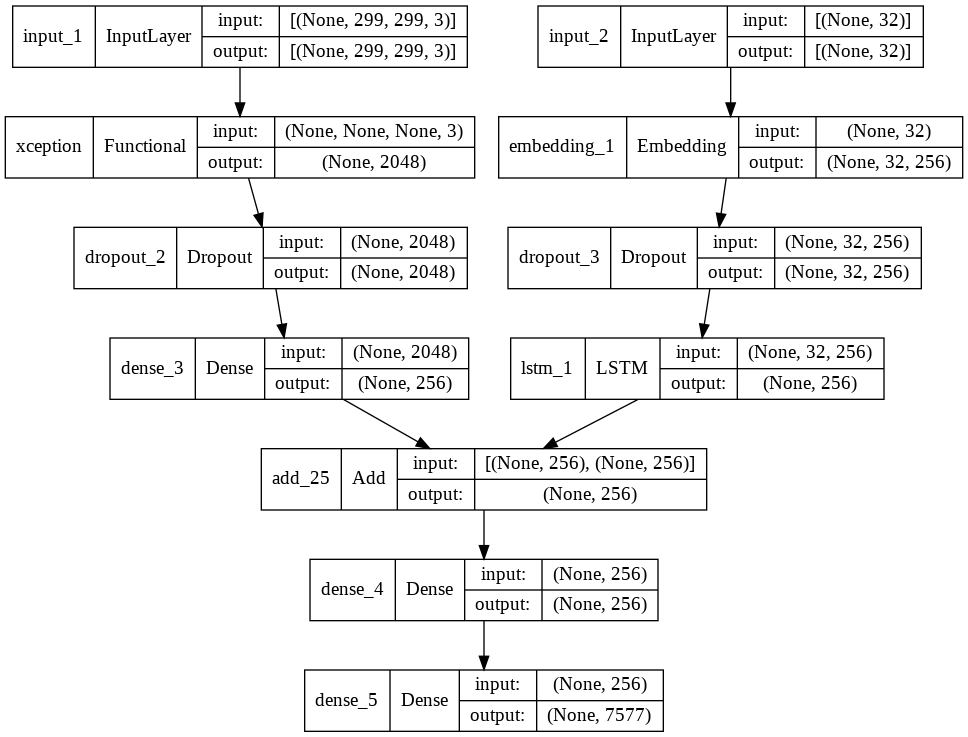

In [87]:
model_path = dataset_folder + '/' + 'model.png'
plot_model(model, to_file=model_path, show_shapes=True)

In [89]:
models_folder =  'models'

In [90]:
steps

6000

In [91]:
gen=CustomDataGen(train_descriptions,train_features,tokenizer,max_length,1,list_keys,data_dir)

In [92]:

model.fit(gen, epochs=1, steps_per_epoch= steps,verbose=1)
model.save("model_combion_full"+ ".h5")

6000/6000 [==============================] - 2691s 448ms/step - loss: 5.4975


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Make a directory models to save our models
models_folder = 'models'
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(gen, epochs=20, steps_per_epoch= steps, verbose=2)
    model.save(models_folder + "/model_new_" + str(i) + ".h5")

# Test Model

We will test the model with different images from the training set and testing set by using differnet models.

In [ ]:
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    # for images that has 4 channels, we convert them into 3 channels
    if image.shape[2] == 4: 
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

In [ ]:
tokenizer_filename = 'tokenizer.p'

In [ ]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word
  return None

In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [ ]:
def test_img(img_path, model):
  max_length = 32
  tokenizer = load(open(tokenizer_filename,"rb"))

  model = load_model('models' + '/' + model)
  # xception_model = Xception(include_top=False, pooling="avg")
  xception_model=load_model('xception_model.h5')

  photo = extract_features(img_path, xception_model)
  img = Image.open(img_path)

  description = generate_desc(model, tokenizer, photo, max_length)
  print(description)
  plt.imshow(img)

## Image in Training Set

In [ ]:
img = '3603116579_4a28a932e2.jpg'
img_path = dataset_images + '/' + img

print('Actual Caption:')
for caption in descriptions[img]:
  print(caption)

Actual Caption:
baseball pitcher with shelton on his shirt throws the ball
baseball player in black and orange shirt and with glove on pitches the ball
male dressed in sports outfit tries to catch baseball
man playing baseball
the baseball player is running after the ball


In [ ]:
img_path

'Flicker8k_Dataset/3603116579_4a28a932e2.jpg'

In [ ]:
model = load_model('xception_model.h5')
k=extract_features(img_path, model)

In [ ]:
k

array([[0.        , 0.        , 0.45290142, ..., 0.8526318 , 0.01047506,
        0.34584808]], dtype=float32)

Predicted Caption:
start baseball player in red and white uniform is playing baseball end


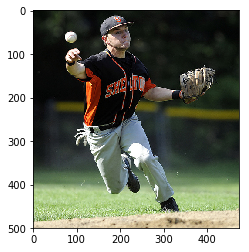

In [ ]:
print('Predicted Caption:')
test_img(img_path, 'model_9.h5')

Predicted Caption:
start baseball player is playing the ball end


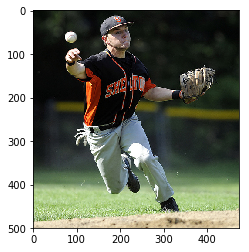

In [ ]:
print('Predicted Caption:')
test_img(img_path, 'model_19.h5')

In [ ]:
img = '2453891449_fedb277908.jpg'
img_path = dataset_images + '/' + img

print('Actual Caption:')
for caption in descriptions[img]:
  print(caption)

Actual Caption:
white dog chasing black dog across the grass
white dog is following black dog through the grassy area
there are two dogs black and white and the black one is jumping
two dogs running in grassy fenced in area surrounded by trees
two dogs running through yard with forest in the distance


Predicted Caption:
start dog is running through the grass end


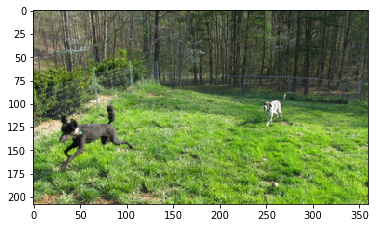

In [ ]:
print('Predicted Caption:')
test_img(img_path, 'model_19.h5')

Predicted Caption:
start dog is running through the grass end


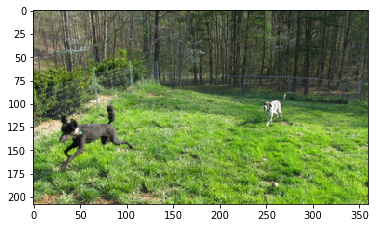

In [ ]:
print('Predicted Caption:')
test_img(img_path, 'model_8.h5')

## Images in Testing Set

In [ ]:
img = '3745451546_fc8ec70cbd.jpg'
img_path = dataset_images + '/' + img

print('Actual Caption:')
for caption in descriptions[img]:
  print(caption)

Actual Caption:
hiker ascends snowy hill
man reaches the top of tall sand dune
person is hiking to the top of hill
person walks up white sandy hill against the blue sky
the person is wearing shorts and climbing gray sand hill under blue sky


Predicted Caption:
start man in red shirt is standing on top of mountain end


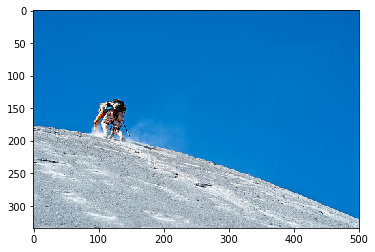

In [ ]:
print('Predicted Caption:')
test_img(img_path, 'model_19.h5')

Predicted Caption:
start man in red jacket is standing on top of mountain end


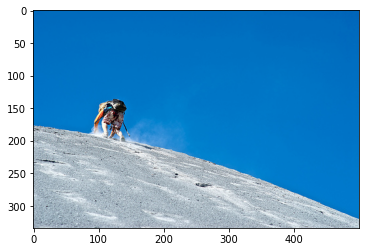

In [ ]:
print('Predicted Caption:')
test_img(img_path, 'model_9.h5')

In [ ]:
img = '2502905671_c6039804ab.jpg'
img_path = dataset_images + '/' + img

print('Actual Caption:')
for caption in descriptions[img]:
  print(caption)

Actual Caption:
black and white dog looks at man about to throw something
dog waits for man to throw ball into the ocean
man playing with his dog on beach
man with toy in his hand on beach playing with his dog
man on rocky beach playing with black and white dog


Predicted Caption:
start man in black shirt is standing on the beach by the ocean end


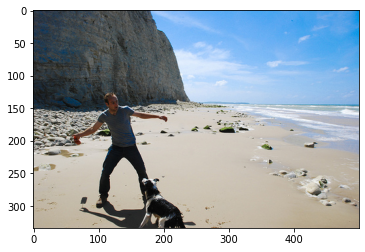

In [ ]:
print('Predicted Caption:')
test_img(img_path, 'model_19.h5')

Predicted Caption:
start man in black shirt is standing on the beach with his head end


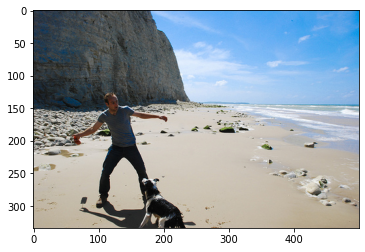

In [ ]:
print('Predicted Caption:')
test_img(img_path, 'model_9.h5')